# Constructing Your Target List 

The Target List contains all of the information about your target stars that is required in order to do integration time calculations.  The Target List is an `EXOSIMS` `TargetList` object (https://exosims.readthedocs.io/en/latest/targetlist.html).  It is generated by copying values from a `StarCatalog` object into standardized, named arrays that are attributes of the `TargetList`.  These values are then used to perform various calculations, to (optionally) filter out stars where a companion object could not be detected, and can be queried to perform integration time calculations.  Here, we will discuss a few different approaches to assembling the Target List required for your specific needs.


If running via Google Colab, you must first execute the contents of notebook `00_Google_Colab_Setup.ipynb` (only if you have never done so previously). Then execute all cells tagged with &#128992;.  If running via a local installation, you should skip all of the colab-specific (&#128992;) cells.

## 🟠 Setup for Google Colab Use

### 🟠 Run the next cell to mount the Google Drive

You will receive some or all of the following prompts:

* Warning: This notebook was not authored by Google - Click "Run Anyway" 
* Permit this notebook to access your Google Drive files? - Click "Connect to Google Drive"
* A new browser window will prompt you to select an account and authorize access
  * Select the Google account you wish to use and click Continue on each subsequent screen until the dialog vanishes

Upon completion of cell execution, you should see `Mounted at /content/drive`

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

### 🟠 Run the next cell to change to the corgietc directory and install the required software

This process should take less than a minute, but, depending on bandwidth availability, may take as long as a few minutes. You will see a variety of messages about package downloads.  Upon completion of cell execution, you should see `Sucessfully installed` followed by a list of installed packages and their versions.

You may see the prompt "Restart session".  You do not need to do this - click 'Cancel'.

In [ ]:
# This cell should *only* be executed if running the notebook in Google Colab
import os

# Google top level drive dir
drive_dir = "/content/drive/MyDrive/"

# directory path
corgietc_dir = 'corgietc'
corgietc_path = os.path.join(drive_dir, corgietc_dir)
cgi_noise_repo_path = os.path.join(corgietc_path, "cgi_noise")
corgietc_repo_path = os.path.join(corgietc_path, "corgietc")
corgietc_notebooks_path = os.path.join(corgietc_repo_path, "Notebooks")

# Change to the cgi_noise repo path and update the repo
os.chdir(cgi_noise_repo_path)
!git pull

# Install the backend and all requirements - this can also take a little while
!pip install .

# Change to the corgietc repo path and update the repo
os.chdir(corgietc_repo_path)
!git pull

# Install the backend and all requirements - this can also take a little while
!pip install .

# Refresh package list to pick up new installations
import site
site.main()

# Change to the Notebooks directory
os.chdir(corgietc_notebooks_path)

### 🟠 Import jupyter widget for Colab

In [ ]:
# need to import third party jupyter widget
from google.colab import output
output.enable_custom_widget_manager()

## All Cells from this point should be run for both Colab and local installations

In [1]:
# import all required packages
from corgietc.corgietc import corgietc
import os
import json
import EXOSIMS.Prototypes.TargetList
import EXOSIMS.Prototypes.TimeKeeping
import copy
import astropy.units as u
import numpy as np
import tempfile
import matplotlib.pyplot as plt

## Generating a Fake Target for Testing

We have already seen this approach in the 'Anatomy of an Integration Time Calculation' notebook.  The prototype (default) `EXOSIMS` `StarCatalog` generates $N$ identical, synthetic targets for testing purposes. If going this route, you can control the number of targets generated (although, as they would all be identical, there's really no point in making more than 1), their V-band magnitude, and their distance.  The last two are controlled by input keywords `VmagFill` and `distFill`, respectively. 

We will load our default input specification and see what those keys are set to there:

In [2]:
scriptfile = os.path.join(os.environ["CORGIETC_DATA_DIR"], "scripts", "CGI_Noise.json")
with open(scriptfile, "r") as f:
    specs = json.loads(f.read())

In [3]:
print(specs["VmagFill"], specs["distFill"])

5 10


So, by default, if using this input spec, we will generate a single target at 10 parsecs with a V-band magnitude of 5.  Let's override the values and check that things work as epxected:

In [4]:
# create a copy of the default input specification
specs1 = copy.deepcopy(specs) 
# update desired input keywords to new values
specs1["distFill"] = 5
specs1["VmagFill"] = 7
# generate the target list
TL1 = EXOSIMS.Prototypes.TargetList.TargetList(**copy.deepcopy(specs1))

Imported StarCatalog (prototype) from EXOSIMS.Prototypes.StarCatalog
Imported corgietc (named file) from /Users/ds264/Do[...]ietc/corgietc/corgietc.py
Imported Stark (implementation) from EXOSIMS.ZodiacalLight.Stark
Imported PostProcessing (prototype) from EXOSIMS.Prototypes.PostProcessing
Imported GalaxiesFaintStars (implementation) from EXOSIMS.BackgroundSources.GalaxiesFaintStars
Imported Completeness (prototype) from EXOSIMS.Prototypes.Completeness
Imported PlanetPopulation (prototype) from EXOSIMS.Prototypes.PlanetPopulation
Imported ForecasterMod (implementation) from EXOSIMS.PlanetPhysicalModel.ForecasterMod
1 targets imported from star catalog.
1 targets remain after removing those where spectral class cannot be established.
1 targets remain after removing white dwarfs and subdwarfs
1 targets remain after nan filtering.
1 targets remain after removing zero luminosity targets.
Loaded JEZ0 values from /Users/ds264/.EXOSIMS/cache/TargetList_StarCatalognStars_1_mode_6534987b1b37fa7

/Users/ds264/Documents/gitrepos/EXOSIMS/EXOSIMS/Prototypes/TargetList.py:381: UserWarning: binary_filter is None but filterBinaries is False. Using binary_filter value of None.
  warnings.warn(


In [5]:
print(TL1.Vmag, TL1.dist)

[7.] [5.] pc


As expected, based on our modified input specification, we have created a Target List consisting of one target, located 5 pc from Earth, and with a V-band magnitude of 7. 

## Generating Lists of Targets with HIP Numbers

`EXOSIMS` provides a `StarCatalog` implementation called `HIPfromSimbad` (https://exosims.readthedocs.io/en/latest/EXOSIMS.StarCatalog.html#module-EXOSIMS.StarCatalog.HIPfromSimbad), which can be used to query the SIMBAD Astronomical Database (https://simbad.u-strasbg.fr/simbad/) for targets by their Hipparcos catalog number.  The HIP numbers are specified either by passing a list of numbers, or by providing a path to a file on disk that contains those numbers (one per row) to the `catalogpath` input keyword.

Let's take a look at how this works:

In [6]:
# create a copy of the default input specification
specs2 = copy.deepcopy(specs)
# update the modules dictionary to use the HIPfromSimbad star catalog
specs2["modules"]["StarCatalog"] = "HIPfromSimbad"
# generate the target list
TL2 = EXOSIMS.Prototypes.TargetList.TargetList(**copy.deepcopy(specs2), catalogpath=[53721])

/Users/ds264/Documents/gitrepos/EXOSIMS/EXOSIMS/Prototypes/TargetList.py:381: UserWarning: binary_filter is None but filterBinaries is False. Using binary_filter value of None.
  warnings.warn(


Imported HIPfromSimbad (implementation) from EXOSIMS.StarCatalog.HIPfromSimbad
Imported corgietc (named file) from /Users/ds264/Do[...]ietc/corgietc/corgietc.py
Imported Stark (implementation) from EXOSIMS.ZodiacalLight.Stark
Imported PostProcessing (prototype) from EXOSIMS.Prototypes.PostProcessing
Imported GalaxiesFaintStars (implementation) from EXOSIMS.BackgroundSources.GalaxiesFaintStars
Imported Completeness (prototype) from EXOSIMS.Prototypes.Completeness
Imported PlanetPopulation (prototype) from EXOSIMS.Prototypes.PlanetPopulation
Imported ForecasterMod (implementation) from EXOSIMS.PlanetPhysicalModel.ForecasterMod
1 targets imported from star catalog.
1 targets remain after removing those where spectral class cannot be established.
1 targets remain after removing white dwarfs and subdwarfs
1 targets remain after nan filtering.
1 targets remain after removing zero luminosity targets.
Cache file not found for mode 6534987b1b37fa7a5002481940edacde. Computing exozodi color facto

Note that we specified the `catalogpath` input directly in the call to the `TargetList` init.  This is common to all `EXOSIMS` modules - you can provide keyword values via the input specification, or directly in calling the init.  The only thing to be careful about is to not specify keywords in the init call that are already present in the input specification (this will lead to an error, as Python won't know which value to use).

The target we selected, HIP 53721 is 47 UMa.  Let's verify that we retrieved the correct one from SIMBAD:

In [7]:
print(f"Name: {TL2.Name}")
print(f"is located at {TL2.coords}")
print(f"and has a V band magnitude of {TL2.Vmag}")

Name: ['HIP 53721']
is located at <SkyCoord (ICRS): (ra, dec, distance) in (deg, deg, pc)
    [(164.86655313, 40.43025571, 13.88753871)]>
and has a V band magnitude of [5.15719986]


## Using Pre-Defined Star Catalogs

``EXOSIMS`` includes a number of other star catalogs.  The two most potentially useful for our purposes are the EXOCAT1 and HPIC catalogs.  EXOCAT1 (https://arxiv.org/abs/1510.01731) provides data on 2347 bright stars within 30 pc of the solar system.  HPIC includes information on over 13000 stars within 50 pc of the solar system.

Using these catalogs can be useful to explore a wide range of stars, however initial setup may take quite a long time due to all of the required pre-computations for such a large number of stars (all of these are cached to disk, however, such that subsequent instantiations go much faster). 

Let's start with EXOCAT1:

In [8]:
# create a copy of the default input specification
specs3 = copy.deepcopy(specs)
# update the modules dictionary to use the HIPfromSimbad star catalog
specs3["modules"]["StarCatalog"] = "EXOCAT1"
# generate the target list
TL3 = EXOSIMS.Prototypes.TargetList.TargetList(**copy.deepcopy(specs3))

/Users/ds264/Documents/gitrepos/EXOSIMS/EXOSIMS/Prototypes/TargetList.py:381: UserWarning: binary_filter is None but filterBinaries is False. Using binary_filter value of None.
  warnings.warn(


Imported EXOCAT1 (implementation) from EXOSIMS.StarCatalog.EXOCAT1
Imported corgietc (named file) from /Users/ds264/Do[...]ietc/corgietc/corgietc.py
Imported Stark (implementation) from EXOSIMS.ZodiacalLight.Stark
Imported PostProcessing (prototype) from EXOSIMS.Prototypes.PostProcessing
Imported GalaxiesFaintStars (implementation) from EXOSIMS.BackgroundSources.GalaxiesFaintStars
Imported Completeness (prototype) from EXOSIMS.Prototypes.Completeness
Imported PlanetPopulation (prototype) from EXOSIMS.Prototypes.PlanetPopulation
Imported ForecasterMod (implementation) from EXOSIMS.PlanetPhysicalModel.ForecasterMod
2347 targets imported from star catalog.
2342 targets remain after removing those where spectral class cannot be established.
2324 targets remain after removing white dwarfs and subdwarfs
2324 targets remain after nan filtering.
2324 targets remain after removing zero luminosity targets.
Cache file not found for mode 6534987b1b37fa7a5002481940edacde. Computing exozodi color fa

Computing exozodi color factors by spectral type: 100%|███████████████████████████████████████████████████████████████████████████████████| 97/97 [00:02<00:00, 33.14it/s]


Star color factors stored in /Users/ds264/.EXOSIMS/cache/TargetList_EXOCAT1_nStars_2324_mode_6534987b1b37fa7a5002481940edacde.color_factors


Computing star fluxes: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 2324/2324 [00:14<00:00, 156.30it/s]


Star fluxes stored in /Users/ds264/.EXOSIMS/cache/TargetList_EXOCAT1_nStars_2324_mode_6534987b1b37fa7a5002481940edacde.star_fluxes
Calculating intCutoff_dMag
intCutoff_dMag values stored in /Users/ds264/.EXOSIMS/cache/TargetList_EXOCAT1_corgietc_Stark_vals_4f54c29487fb3f9f58dd4728a99b7385_mode_6534987b1b37fa7a5002481940edacde.intCutoff_dMag
Calculating the integration cutoff time completeness
intCutoff_comp values stored in /Users/ds264/.EXOSIMS/cache/TargetList_EXOCAT1_Completeness_vals_c12299daf21f4c9b9762a2c2d276b56c.intCutoff_comp


Notice that in this case, the TargetList actually did some filtering on the input star catalog (the filtering information is being printed out because we have keyword `explainFiltering` set to True in our default input specification.   We can verify the filtering messages by printing out the number of remaining targets in our final list (this is stored in the `nStars` attribute:

In [9]:
print(TL3.nStars)

2324


The values copied from the original star catalog (or added during instantiation of the Target List) are stored in attribute `catalog_atts`:

In [10]:
TL3.catalog_atts

['Name',
 'Spec',
 'parx',
 'dist',
 'coords',
 'pmra',
 'pmdec',
 'rv',
 'Umag',
 'Bmag',
 'Vmag',
 'Rmag',
 'Imag',
 'Jmag',
 'Hmag',
 'Kmag',
 'BV',
 'MV',
 'BC',
 'L',
 'Binary_Cut',
 'spectral_class',
 'Teff',
 'MsEst',
 'MsTrue',
 'diameter',
 'blackbody_spectra',
 'int_dMag',
 'int_WA',
 'intCutoff_dMag',
 'intCutoff_comp',
 'saturation_dMag',
 'saturation_comp',
 'int_tmin',
 'int_comp',
 'hasKnownPlanet']

NB: Just because a key exists, does not guarantee that it is fully populated.  That depends largely on what was available in the original catalog. 

Let's visualize the contents of EXOCAT1:

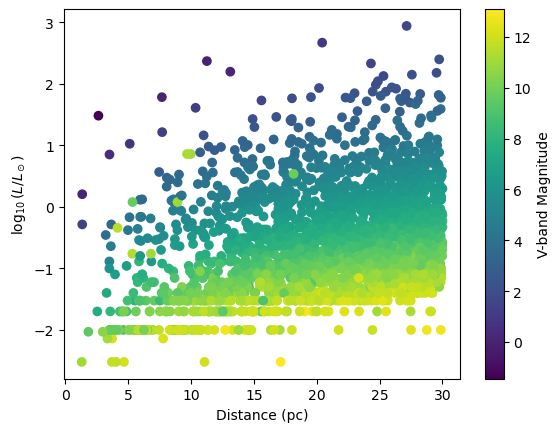

In [11]:
fig1, ax1 = plt.subplots()
pts = ax1.scatter(TL3.dist, np.log10(TL3.L), c=TL3.Vmag)
ax1.set_xlabel("Distance (pc)")
ax1.set_ylabel("$\log_{10}(L/L_\odot)$")
plt.colorbar(pts, label=f"V-band Magnitude");

We can also try to identify specific targets by name, although this requires knowledge of the naming scheme used by the star catalog.  EXOCAT uses HIP identifiers, but also adds star letters for multiple systems that are not resolved in the original Hipparcos catalog. That is, both $\alpha$ Cen A and B are present in EXOCAT (with names "HIP 71683" and "HIP 71681", respectively), but something like HD 224953A will be listed as "HIP 169 A".  Let's try to locate 47 UMa again:

In [12]:
sInd = np.where(TL3.Name == "HIP 53721")[0]
print(f"Name: {TL3.Name[sInd]}")
print(f"is located at {TL3.coords[sInd]}")
print(f"and has a V band magnitude of {TL3.Vmag[sInd]}")

Name: ['HIP 53721']
is located at <SkyCoord (ICRS): (ra, dec, distance) in (deg, deg, pc)
    [(164.86757, 40.430122, 14.06)]>
and has a V band magnitude of [5.03]


Note that the information here does not quite match what we queried from SIMBAD, above.  This is primarily due to EXOCAT's age (it was published in 2015).

## Creating a Fully Custom Input Catalog

If none of the options above suit your needs, you can create a fully custom catalog.  This involves implementing a Python class that inherits the ``EXOSIMS`` prototype ``StarCatalog``.  Below is a (relatively) simple example.  This catalog allows you to specify target distances, coordinates, V-band magnitudes, spectral types, and bolometric luminosities (this is the minimal set of things `EXOSIMS` needs to perform basic calculations). Default values are provided that are roughly equivalent to a solar twin at 10 pc.

The one (minor) difficulty is getting this new code integrated with EXOSIMS.  We need for the source of the class to be written to disk so that `EXOSIMS` can properly loaded.  If working offline, this just requires you to create a new file (called `CustomCatalog.py` - all `EXOSIMS` classes must be in files of the same name as the class) and saving it anywhere on disk.  Then we can reference the module by its full path on disk in the input specification.  If working on Colab, you can similarly save the file anywhere in your mounted Google drive, and reference its location there. 

To ensure that this example works regardless of where you're executing it, we will write the source of our class to the system tmp directory (which is guaranteed to exist and be writeable on practically any system):

In [13]:
sourcecode = """
from EXOSIMS.Prototypes.StarCatalog import StarCatalog
import numpy as np
import astropy.units as u
import random as py_random
from astropy.coordinates import SkyCoord


class CustomCatalog(StarCatalog):
    \"\"\"Custom Catalog class
    This class generates a star catalog based solely on user inputs

    Args:
        star_dist (ArrayLike):
            Target distance (pc)
        star_ra (ArrayLike):
            Target RA (deg)
        star_dec (ArrayLike):
            Target Dec (deg)
        star_Vmag (ArrayLike):
            Target V band apparent mag
        star_spectype (ArrayLike):
            Target spectral type (e.g. G2V)
        star_L (ArrayLike):
            Target luminosity in solar luminosities

    Note:
        All inputs must be scalars or equal dimension list/array. If you make one a
        list, you must change all of them.
    \"\"\"

    def __init__(
        self,
        star_dist=10,
        star_ra=0,
        star_dec=0,
        star_Vmag=4.83,
        star_spectype="G2V",
        star_L=1,
        **specs
    ):

        StarCatalog.__init__(
            self,
            ntargs=len(np.array(star_dist, ndmin=1)),
            **specs
        )

        self.Vmag = np.array(star_Vmag, ndmin=1) # V magnitude
        self.dist = np.array(star_dist, ndmin=1) * u.pc  # distance
        self.parx = self.dist.to("mas", equivalencies=u.parallax())  # parallax
        self.coords = SkyCoord(
            ra=np.array(star_ra, ndmin=1) * u.deg,
            dec=np.array(star_dec, ndmin=1) * u.deg,
            distance=self.dist,
        )
        self.L = np.array(star_L, ndmin=1)
        self.MV = self.Vmag - 5 * (np.log10(self.dist.value) - 1)  # abs V mag
        BMsun = 4.74
        self.BC = BMsun - self.MV - 2.5 * np.log10(self.L)  # bolometric correction
        self.Spec = np.array(star_spectype, ndmin=1)
"""

tmpdir = tempfile.gettempdir()
filepath = os.path.join(tmpdir, "CustomCatalog.py")
with open(filepath, "w") as f:
    f.write(sourcecode)

We are now ready to use this new catalog.  Let's try generating two different targets.

In [14]:
# create a copy of the default input specification
specs4 = copy.deepcopy(specs)
# update the modules dictionary to use the HIPfromSimbad star catalog
specs4["modules"]["StarCatalog"] = filepath
# generate the target list
TL4 = EXOSIMS.Prototypes.TargetList.TargetList(**copy.deepcopy(specs4),
                                              star_dist = [5, 10],
                                              star_ra = [100, 70],
                                              star_dec = [30,-30],
                                              star_Vmag = [3, 7],
                                              star_spectype = ["G0V", "K5V"],
                                              star_L = [1.3, 0.17])

/Users/ds264/Documents/gitrepos/EXOSIMS/EXOSIMS/Prototypes/TargetList.py:381: UserWarning: binary_filter is None but filterBinaries is False. Using binary_filter value of None.
  warnings.warn(


Imported CustomCatalog (named file) from /var/folders/2r[...]0000gn/T/CustomCatalog.py
Imported corgietc (named file) from /Users/ds264/Do[...]ietc/corgietc/corgietc.py
Imported Stark (implementation) from EXOSIMS.ZodiacalLight.Stark
Imported PostProcessing (prototype) from EXOSIMS.Prototypes.PostProcessing
Imported GalaxiesFaintStars (implementation) from EXOSIMS.BackgroundSources.GalaxiesFaintStars
Imported Completeness (prototype) from EXOSIMS.Prototypes.Completeness
Imported PlanetPopulation (prototype) from EXOSIMS.Prototypes.PlanetPopulation
Imported ForecasterMod (implementation) from EXOSIMS.PlanetPhysicalModel.ForecasterMod
2 targets imported from star catalog.
2 targets remain after removing those where spectral class cannot be established.
2 targets remain after removing white dwarfs and subdwarfs
2 targets remain after nan filtering.
2 targets remain after removing zero luminosity targets.
Cache file not found for mode 6534987b1b37fa7a5002481940edacde. Computing exozodi col

In [15]:
print(f"Names: {TL4.Name}")
print(f"coordinates: {TL4.coords}")
print(f"V band magnitudes: {TL4.Vmag}")

Names: ['Prototype Star 0' 'Prototype Star 1']
coordinates: <SkyCoord (ICRS): (ra, dec, distance) in (deg, deg, pc)
    [(100.,  30.,  5.), ( 70., -30., 10.)]>
V band magnitudes: [3 7]
